In [1]:
import os

base_path = "/home/intern/Desktop/25-1/DL/dataset/"
categories = ["normal", "schizophrenia"]

for category in categories:
    folder_path = os.path.join(base_path, category)
    files = os.listdir(folder_path)
    print(f"{category} 폴더의 파일 개수: {len(files)}")

normal 폴더의 파일 개수: 39
schizophrenia 폴더의 파일 개수: 45


In [2]:
import os
import torch
from torch.backends import cudnn
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

def set_seed(random_seed=42):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)
    torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device} - {torch.cuda.get_device_name(device)}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

def prepare_model_for_multigpu(model):
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        print("Using multiple GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    return model

GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000


# Preprocessing

In [4]:
import numpy as np

X = np.load("EEG_data.npy", allow_pickle=True)   # 객체 배열인 경우 allow_pickle=True 필요
y = np.load("EEG_labels.npy")
skipped_files = np.load("Skipped_files.npy", allow_pickle=True)

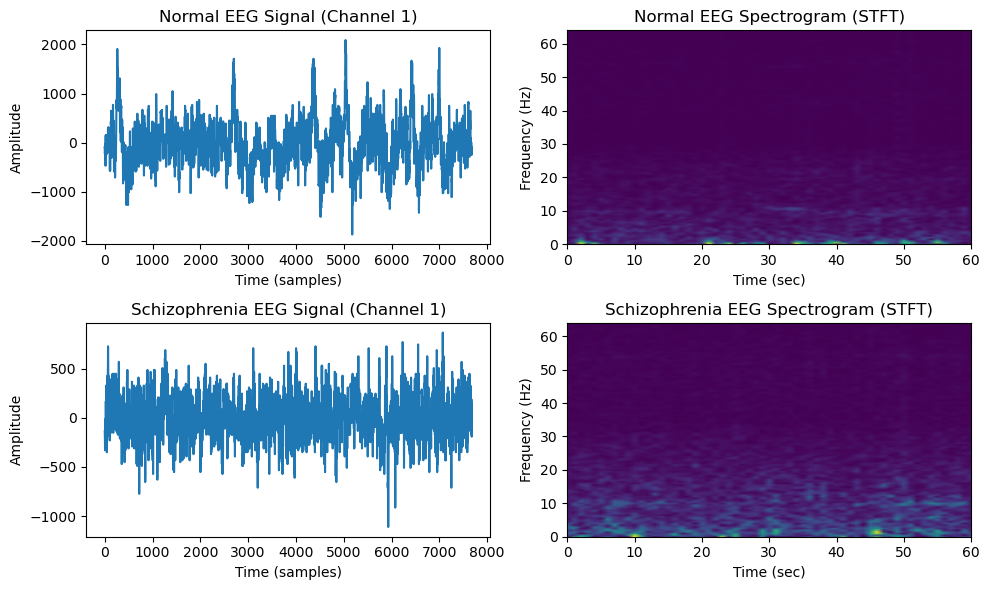

In [6]:
# 정상(Normal)과 조현병(Schizophrenia) 샘플 하나씩 선택
normal_indices = np.where(y == 0)[0]  # 정상 데이터 인덱스 리스트
schizo_indices = np.where(y == 1)[0]  # 조현병 데이터 인덱스 리스트

if len(normal_indices) == 0 or len(schizo_indices) == 0:
    raise ValueError("정상 또는 조현병 데이터가 없습니다!")

normal_sample = X[normal_indices[0]]  # 첫 번째 정상 데이터
schizo_sample = X[schizo_indices[0]]  # 첫 번째 조현병 데이터

# 특정 채널 선택 (예: 1번 채널)
channel_idx = 0
normal_signal = normal_sample[channel_idx]
schizo_signal = schizo_sample[channel_idx]

# 주파수 변환 (Short-Time Fourier Transform, STFT)
fs = 128  # 샘플링 레이트 (Hz)
import scipy.signal
f_norm, t_norm, Zxx_norm = scipy.signal.stft(normal_signal, fs=fs, nperseg=256)
f_schizo, t_schizo, Zxx_schizo = scipy.signal.stft(schizo_signal, fs=fs, nperseg=256)

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 정상 EEG 시각화
plt.subplot(2, 2, 1)
plt.plot(normal_signal)
plt.title("Normal EEG Signal (Channel 1)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 2)
plt.pcolormesh(t_norm, f_norm, np.abs(Zxx_norm), shading='gouraud')
plt.title("Normal EEG Spectrogram (STFT)")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

# 조현병 EEG 시각화
plt.subplot(2, 2, 3)
plt.plot(schizo_signal)
plt.title("Schizophrenia EEG Signal (Channel 1)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 4)
plt.pcolormesh(t_schizo, f_schizo, np.abs(Zxx_schizo), shading='gouraud')
plt.title("Schizophrenia EEG Spectrogram (STFT)")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

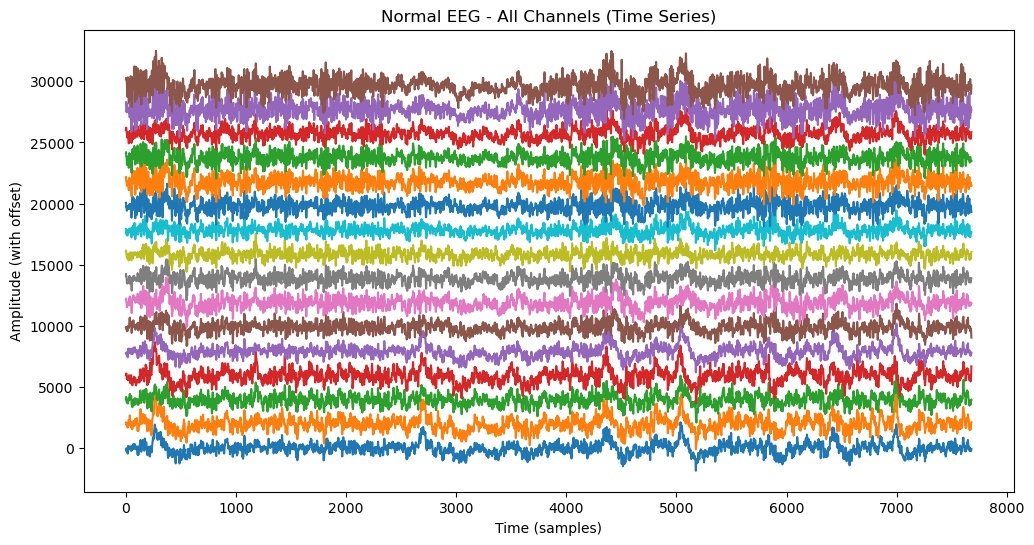

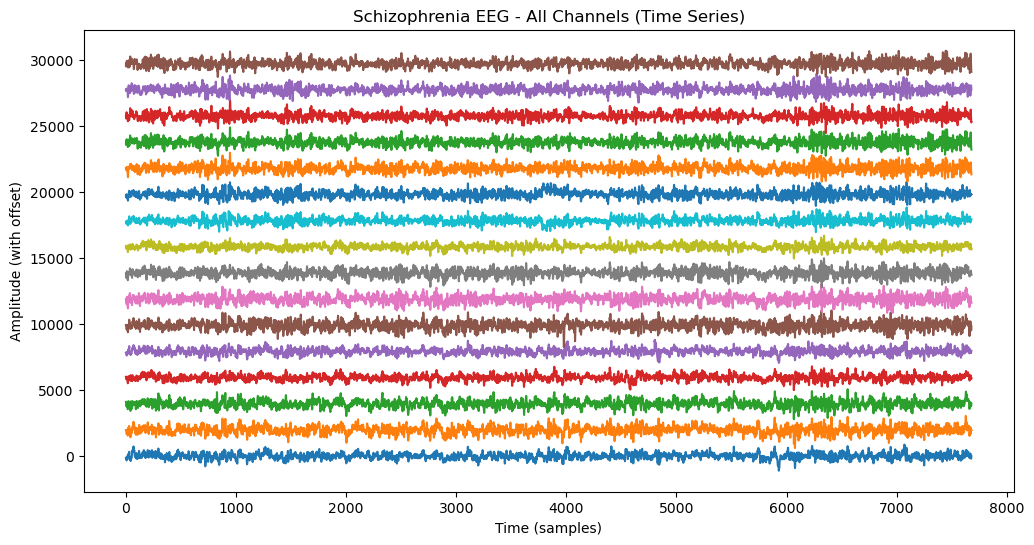

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# (channels, samples) 형태의 배열이라고 가정
num_channels, num_samples = normal_sample.shape
num_channels, num_samples = schizo_sample.shape

# 각 채널의 최대 절대값에 약간의 여유를 두어 오프셋을 정함
offset = np.max(np.abs(normal_sample)) * 1.2
offset = np.max(np.abs(schizo_sample)) * 1.2

plt.figure(figsize=(12, 6))
for ch in range(num_channels):
    plt.plot(normal_sample[ch] + ch * offset, label=f'Channel {ch+1}')
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (with offset)")
plt.title("Normal EEG - All Channels (Time Series)")
plt.show()

plt.figure(figsize=(12, 6))
for ch in range(num_channels):
    plt.plot(schizo_sample[ch] + ch * offset, label=f'Channel {ch+1}')
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (with offset)")
plt.title("Schizophrenia EEG - All Channels (Time Series)")
plt.show()

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import zscore

# 1. Filtering functions
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)

def notch_filter(data, freq, fs, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data, axis=-1)

# 2. Normalization: 각 채널별 z-score 정규화
def normalize_data(data):
    return zscore(data, axis=1)

# 3. Epoching: 데이터를 epoch_length 길이의 에포크로 분할
def epoch_data(data, epoch_length):
    total_samples = data.shape[1]
    num_epochs = total_samples // epoch_length
    epochs = data[:, :num_epochs * epoch_length].reshape(data.shape[0], num_epochs, epoch_length)
    epochs = np.transpose(epochs, (1, 0, 2))  # (num_epochs, channels, epoch_length)
    return epochs

# 4. Artifact removal
def remove_artifacts(epochs, threshold):
    clean_epochs = []
    for epoch in epochs:
        if np.max(np.abs(epoch)) < threshold:
            clean_epochs.append(epoch)
    return np.array(clean_epochs)

# Parameters
fs = 256
lowcut = 1.0
highcut = 50.0
notch_freq = 50.0
epoch_length = 512
artifact_threshold = 100

# X = np.load("EEG_data_cleaned.npy", allow_pickle=True)
# y = np.load("EEG_labels.npy", allow_pickle=True)

processed_epochs = []
subject_labels = []

for i, data in enumerate(X):
    # data shape: (channels, total_samples)
    data_filtered = bandpass_filter(data, lowcut, highcut, fs)
    data_filtered = notch_filter(data_filtered, notch_freq, fs)
    data_norm = normalize_data(data_filtered)
    epochs = epoch_data(data_norm, epoch_length)
    clean_epochs = remove_artifacts(epochs, artifact_threshold)

    if clean_epochs.size == 0:
        print(f"Subject {i} (label {y[i]}) has no clean epochs after artifact removal. Skipping.")
        continue

    processed_epochs.append(clean_epochs)
    subject_labels.append(y[i])

print("Preprocessing complete.")
print(f"Number of subjects processed: {len(processed_epochs)}")
for i, ep in enumerate(processed_epochs):
    print(f"Subject {i} (label {subject_labels[i]}): {ep.shape[0]} clean epochs, shape {ep.shape[1:]} per epoch")

np.save("Processed_epochs_time.npy", processed_epochs)
np.save("Subject_labels_time.npy", np.array(subject_labels))

Preprocessing complete.
Number of subjects processed: 61
Subject 0 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 1 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 2 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 3 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 4 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 5 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 6 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 7 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 8 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 9 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 10 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 11 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 12 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 13 (label 0): 15 clean epochs, shape (16, 512) per epoch
Subject 14 (label 0): 15 clean epochs, shap

## 2D

### Before Aug 

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

processed_epochs = np.load("Processed_epochs.npy", allow_pickle=True)
subject_labels = np.load("Subject_labels.npy", allow_pickle=True)
subject_labels = np.array(subject_labels)

# processed_epochs는 각 subject마다 (num_epochs, channels, epoch_length) 배열을 가진 리스트

# Subject-level로 train/val/test split (예: 60% train, 20% val, 20% test)
num_subjects = len(processed_epochs)
subject_indices = np.arange(num_subjects)
train_idx, temp_idx, _, temp_labels = train_test_split(
    subject_indices, subject_labels, test_size=0.4, random_state=42, stratify=subject_labels)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# 각 subject의 에포크들을 하나의 dataset으로 결합하는 함수
def combine_epochs(indices, processed_epochs, subject_labels):
    X = []
    y = []
    for idx in indices:
        epochs = processed_epochs[idx]  # shape: (num_epochs, channels, epoch_length)
        label = subject_labels[idx]
        for epoch in epochs:
            X.append(epoch)
            y.append(label)
    X = np.array(X)  # shape: (total_epochs, channels, epoch_length)
    y = np.array(y)
    return X, y

X_train_np, y_train_np = combine_epochs(train_idx, processed_epochs, subject_labels)
X_val_np, y_val_np     = combine_epochs(val_idx, processed_epochs, subject_labels)
X_test_np, y_test_np   = combine_epochs(test_idx, processed_epochs, subject_labels)

print("Train shape:", X_train_np.shape, y_train_np.shape)
print("Validation shape:", X_val_np.shape, y_val_np.shape)
print("Test shape:", X_test_np.shape, y_test_np.shape)

Train shape: (540, 16, 512) (540,)
Validation shape: (180, 16, 512) (180,)
Test shape: (195, 16, 512) (195,)


In [6]:
# PyTorch Dataset 구성
class EEGDataset(Dataset):
    def __init__(self, X, y):
        # X: (epochs, channels, epoch_length)
        # CNN 모델 입력을 위해 채널 차원(1)을 추가하여 (epochs, 1, channels, epoch_length)로 만듦
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EEGDataset(X_train_np, y_train_np)
val_dataset   = EEGDataset(X_val_np, y_val_np)
test_dataset  = EEGDataset(X_test_np, y_test_np)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# GroupNorm을 간편하게 적용하기 위한 헬퍼 함수
def group_norm(num_channels):
    groups = 8 if num_channels % 8 == 0 else 1
    return nn.GroupNorm(groups, num_channels)

class SEBlock3D(nn.Module):
    def __init__(self, channels, reduction=8, dropout_rate=0.3):
        super(SEBlock3D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.BatchNorm1d(channels // reduction),  
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, d, h, w = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y

class ECABlock3D(nn.Module):
    def __init__(self, channels, k_size=3):
        super(ECABlock3D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size-1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        y = self.avg_pool(x)              
        y = y.view(x.size(0), 1, x.size(1)) 
        y = self.conv(y)                  
        y = self.sigmoid(y)               
        y = y.view(x.size(0), x.size(1), 1, 1, 1)  
        return x * y
        
class ResidualFirstBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16, dropout_rate=0):
        super(ResidualFirstBlock3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=7, padding=3, bias=False),
            group_norm(out_channels),
            nn.GELU(),
            nn.Dropout3d(dropout_rate)
        )
        self.eca = ECABlock3D(out_channels, k_size=7)
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, padding=0, bias=False),
                group_norm(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        out = self.conv(x)
        out = self.eca(out)
        shortcut = self.shortcut(x)
        return F.gelu(out + shortcut)
        
class ResidualConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16, dropout_rate=0.3):
        super(ResidualConvBlock3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            group_norm(out_channels),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.GELU(),
            nn.Dropout3d(dropout_rate)
        )
        self.eca = ECABlock3D(out_channels, k_size=3)
        self.shortcut = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False),
            group_norm(out_channels)
        )
    
    def forward(self, x):
        out = self.conv(x)
        out = self.eca(out)
        shortcut = self.shortcut(x)
        return F.gelu(out + shortcut)

class ResidualFifthBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16, dropout_rate=0.5):
        super(ResidualFifthBlock3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=1, padding=0, bias=False),
            group_norm(out_channels),
            nn.GELU(),
            nn.Dropout3d(dropout_rate)
        )
        self.eca = ECABlock3D(out_channels, k_size=3)
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, padding=0, bias=False),
                group_norm(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        out = self.conv(x)
        out = self.eca(out)
        shortcut = self.shortcut(x)
        return F.gelu(out + shortcut)

class SFCN3D_GroupNorm(nn.Module):
    def __init__(self, num_classes=2):
        super(SFCN3D_GroupNorm, self).__init__()
        self.input_norm = nn.InstanceNorm3d(1, affine=True)
        self.layer1 = ResidualFirstBlock3D(1, 16, reduction=8, dropout_rate=0)
        self.layer2 = ResidualConvBlock3D(16, 32, reduction=8, dropout_rate=0)
        self.layer3 = ResidualConvBlock3D(32, 64, reduction=8, dropout_rate=0.2)
        self.layer4 = ResidualConvBlock3D(64, 128, reduction=8, dropout_rate=0.3)
        self.layer5 = ResidualFifthBlock3D(128, 256, reduction=8, dropout_rate=0.5)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        self.layer6 = nn.Conv3d(256, num_classes, kernel_size=1, padding=0, bias=False) 
    
    def forward(self, x):
        x = self.input_norm(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)
        return x

In [10]:
# 5. 간단한 2D CNN 모델 구성
class EEGCNN(nn.Module):
    def __init__(self, in_channels, H, W):
        super(EEGCNN, self).__init__()
        # in_channels = 1, H: number of EEG channels, W: epoch_length (samples)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        
        # 계산: 입력 H x W -> after pool1: (H/2, W/2), after pool2: (H/4, W/4)
        self.flattened_size = 64 * (H // 4) * (W // 4)
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # 2-class classification
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 데이터의 shape: (N, 1, channels, epoch_length)
_, _, H, W = next(iter(train_loader))[0].shape
#model = EEGCNN(in_channels=1, H=H, W=W)
model = SFCN3D_GroupNorm()
print(model)

# 6. Loss, Optimizer, 그리고 학습 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = running_loss_val / total_val
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# 7. Test 평가
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_acc = correct_test / total_test
print("Test Accuracy:", test_acc)

SFCN3D_GroupNorm(
  (input_norm): InstanceNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (layer1): ResidualFirstBlock3D(
    (conv): Sequential(
      (0): Conv3d(1, 16, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
      (1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Dropout3d(p=0, inplace=False)
    )
    (eca): ECABlock3D(
      (avg_pool): AdaptiveAvgPool3d(output_size=1)
      (conv): Conv1d(1, 1, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (sigmoid): Sigmoid()
    )
    (shortcut): Sequential(
      (0): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (1): GroupNorm(8, 16, eps=1e-05, affine=True)
    )
  )
  (layer2): ResidualConvBlock3D(
    (conv): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): MaxPool3d(kernel

RuntimeError: weight should contain 32 elements not 1

#### Train Valid

In [ ]:
from tqdm import tqdm
import segmentation_models_pytorch as smp
import torch.nn.functional as F

def train(model, train_loader, optimizer, device):
    total_dice_loss = 0
    class_weights = torch.tensor([5.0, 3.0, 1.0])
    criterion1 = nn.CrossEntropyLoss(weight=class_weights.to(device))
    #criterion1 = nn.CrossEntropyLoss() #OrdinalCELoss() #smp.losses.DiceLoss(mode='multiclass')

    model.train() #
    trainl = len(train_loader)
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) # inputs (batch_size, num_classes, depth, height, width) / labels (batch_size, class)
        optimizer.zero_grad()
        prediction = model(inputs)
        #prediction = prediction.view(batch_size, num_classes, depth, height, width) # prediction의 형태를 맞추기 위해 변환
        labels = labels.squeeze() 
        
        #print("Outputs shape: ", prediction.shape)
        #print("Targets shape: ", labels.shape)

        dice_loss = criterion1(prediction, labels) # labels
        dice_loss.backward() # 위치 체인지
        optimizer.step() # 위치 체인지
        
        total_dice_loss += dice_loss.item()

    return total_dice_loss/trainl 

def valid(model, val_loader, device):
    total_dice_loss = 0
    criterion1 = nn.CrossEntropyLoss() #OrdinalCELoss() #smp.losses.DiceLoss(mode='multiclass')

    model.eval() #
    vall = len(val_loader)
    with torch.no_grad(): #
        for inputs, labels in tqdm(val_loader): # for inputs, labels, _ in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long() #
            prediction = model(inputs)
            labels = labels.squeeze()
            #prediction = torch.argmax(prediction, dim=1)
            
            dice_loss = criterion1(prediction, labels) # labels
            total_dice_loss += dice_loss.item()

    return total_dice_loss/vall 

In [ ]:
import copy
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR

train_dice, valid_dice = [], []
best_loss = float('inf')
ch_epochs = 300
patience = 40
epochs_without_improvement = 0
torch.autograd.set_detect_anomaly(True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-4)

checkpoint_dir = '/home/intern/intern/.ipynb_checkpoints/25_winter'
os.makedirs(checkpoint_dir, exist_ok=True)
sd_PATH_regressor = os.path.join(checkpoint_dir, 'ResNet10.pth') # 파일명 바꾸기 잊지 말기

for epoch in range(ch_epochs):
    print(f"# Epoch {epoch+1}")
    train_dice_loss = train(model, train_loader, optimizer, device)
    valid_dice_loss = valid(model, test_loader, device) ##
    train_dice.append(train_dice_loss)
    valid_dice.append(valid_dice_loss)
    valid_loss = valid_dice_loss 
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model_sd = copy.deepcopy(model.state_dict())
        torch.save(best_model_sd, sd_PATH_regressor)
        print('model saved')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

In [ ]:
import torch
import matplotlib.pyplot as plt

def move_to_cpu(tensor):
    """Move a tensor to the CPU and convert it to a numpy array if needed."""
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy()
    return tensor
    
def graph_results(train_losses, valid_losses):
    train_losses = [move_to_cpu(item) for item in train_losses]
    valid_losses = [move_to_cpu(item) for item in valid_losses]
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

graph_results(train_dice, valid_dice)

#### Test

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics

def plot_confusion_matrix1(predictions, actuals, num_classes=3):
    cm = confusion_matrix(actuals, predictions, labels=range(num_classes))

    plt.figure(figsize=(8, 6))
    #err : not showing all values
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2])
    cm_display.plot(cmap='Blues')
    #plt.xlabel('Predicted')
    #plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_confusion_matrix2(predictions, actuals, num_classes=3):
    cm = confusion_matrix(actuals, predictions, labels=range(num_classes))
    df_cm = pd.DataFrame(cm, index=[f"True {l}" for l in range(num_classes)], columns=[f"Pred {l}" for l in range(num_classes)])
    print(df_cm)

In [ ]:
best_model = model
best_model.load_state_dict(torch.load('/home/intern/Desktop/.ipynb_checkpoints/25_winter/SFCN_Att.pth'), strict=False) # 파일명 확인
best_model.to(device)
best_model.eval()  # Set the model to evaluation mode


def test(model, device, test_loader):
    best_model.eval()
    test_loss = 0
    correct = 0
    all_predictions = []
    all_actuals = []
    criterion1 = FocalLoss(alpha=0.5, gamma=2, reduction='mean')
    #criterion1 = nn.CrossEntropyLoss(label_smoothing=0.1)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            outputs = best_model(inputs)
            #outputs = outputs.select(dim=-1, index=0)
            labels = labels.squeeze()
            loss = criterion1(outputs, labels) #
            test_loss += loss.item()
            pred = torch.argmax(outputs, dim=1)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            all_predictions.append(pred.cpu())
            all_actuals.append(labels.cpu())
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return all_predictions, all_actuals, test_loss

all_predictions, all_actuals, test_loss = test(best_model, device, test_loader)

all_predictions = torch.cat(all_predictions)
all_actuals = torch.cat(all_actuals)

print(f"🔍 Shape of all_predictions: {all_predictions.shape}, Unique values: {np.unique(all_predictions)}")
print(f"🔍 Shape of all_actuals: {all_actuals.shape}, Unique values: {np.unique(all_actuals)}")

#print(f"Shape of all_predictions: {all_predictions.shape}")
#print(f"Shape of all_actuals: {all_actuals.shape}")
plot_confusion_matrix1(all_predictions.numpy(), all_actuals.numpy(), num_classes=3)
plot_confusion_matrix2(all_predictions.numpy(), all_actuals.numpy(), num_classes=3)